## Dataset Creation

In [1]:
%pip install bing-image-downloader

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from bing_image_downloader import downloader

# Define the categories
categories = ['deer', 'parrot']
image_count = 100

# Download the images
for category in categories:
    downloader.download(category, limit=image_count, output_dir='data', adult_filter_off=True, force_replace=False, timeout=60)

[%] Downloading Images to c:\Users\aashm\OneDrive\Desktop\ES335_gradient_thinkers\A4\data\deer


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from https://cdn.britannica.com/40/109040-050-62EEDEA6/Male-white-tailed-deer.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://upload.wikimedia.org/wikipedia/commons/f/f3/Fallow_deer_in_field.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://upload.wikimedia.org/wikipedia/commons/0/09/White-tailed_deer_at_Greenough_Park,_Missoula.JPG
[%] File Downloaded !

[%] Downloading Image #4 from http://matthansenphotography.com/wp-content/uploads/2017/03/whitetail-deer-photography_mhp_082900086.jpg
[%] File Downloaded !

[%] Downloading Image #5 from http://upload.wikimedia.org/wikipedia/commons/b/b7/White-tailed_deer.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http://upload.wikimedia.org/wikipedia/commons/5/50/Red_deer_stag_2009_denmark.jpg
[%] File Downloaded !

[%] Downloadi

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

original_dir = 'data'
deer_dir = os.path.join(original_dir, 'deer')
parrot_dir = os.path.join(original_dir, 'parrot')

train_dir = os.path.join(original_dir, 'train')
test_dir = os.path.join(original_dir, 'test')

deer_train_dir = os.path.join(train_dir, 'deer')
deer_test_dir = os.path.join(test_dir, 'deer')
parrot_train_dir = os.path.join(train_dir, 'parrot')
parrot_test_dir = os.path.join(test_dir, 'parrot')

# Create the new directories if they don't exist
os.makedirs(deer_train_dir, exist_ok=True)
os.makedirs(deer_test_dir, exist_ok=True)
os.makedirs(parrot_train_dir, exist_ok=True)
os.makedirs(parrot_test_dir, exist_ok=True)

# Function to split the data
def split_data(src_dir, train_dir, test_dir, test_size=0.2):
    files = os.listdir(src_dir)
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    for file in train_files:
        shutil.move(os.path.join(src_dir, file), os.path.join(train_dir, file))

    for file in test_files:
        shutil.move(os.path.join(src_dir, file), os.path.join(test_dir, file))

split_data(deer_dir, deer_train_dir, deer_test_dir)
split_data(parrot_dir, parrot_train_dir, parrot_test_dir)

# Remove the old directories (if they are empty)
if not os.listdir(deer_dir):
    os.rmdir(deer_dir)

if not os.listdir(parrot_dir):
    os.rmdir(parrot_dir) 

## Binary Classifcation

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.optimizers import Adam
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard

In [4]:
train_dir = 'data/train'
test_dir = 'data/test'

datagen = ImageDataGenerator(rescale=1./255)

# Load the training images without augmentation
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary'
)

# Load the test images
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary'
)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [1]:
def evaluate_model(model, history):
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

    training_loss = history.history['loss'][-1]
    training_accuracy = history.history['accuracy'][-1]

    return {
        "training_loss": training_loss,
        "training_accuracy": training_accuracy,
        "test_accuracy": test_accuracy,
        "num_parameters": model.count_params()
    }

In [2]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

### VGG (1 Block)

In [12]:
def vgg_1_block():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
model_1 = vgg_1_block()
history_1 = model_1.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    verbose=1
)

results_1 = evaluate_model(model_1, history_1)
print(f"Model 1 Results: {results_1}")

c:\Users\aashm\OneDrive\Desktop\ES335_gradient_thinkers\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\aashm\OneDrive\Desktop\ES335_gradient_thinkers\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.5331 - loss: 1.6568 - val_accuracy: 0.5000 - val_loss: 2.0784
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5117 - loss: 1.5801 - val_accuracy: 0.5000 - val_loss: 0.6802
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.5573 - loss: 0.6458 - val_accuracy: 0.5000 - val_loss: 0.7264
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.5112 - loss: 0.6447 - val_accuracy: 0.6000 - val_loss: 0.6384
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8770 - loss: 0.5411 - val_accuracy: 0.7000 - val_loss: 0.5783
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9120 - loss: 0.4261 - val_accuracy: 0.6250 - val_loss: 0.6009
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8473 - loss: 0.3678 - val_accuracy: 0.7250 - val_loss: 0.5124
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8375 - loss: 0.3065 - val_accuracy: 0.8000 - val_loss: 0.4760
Epoch 9/10
3/3 

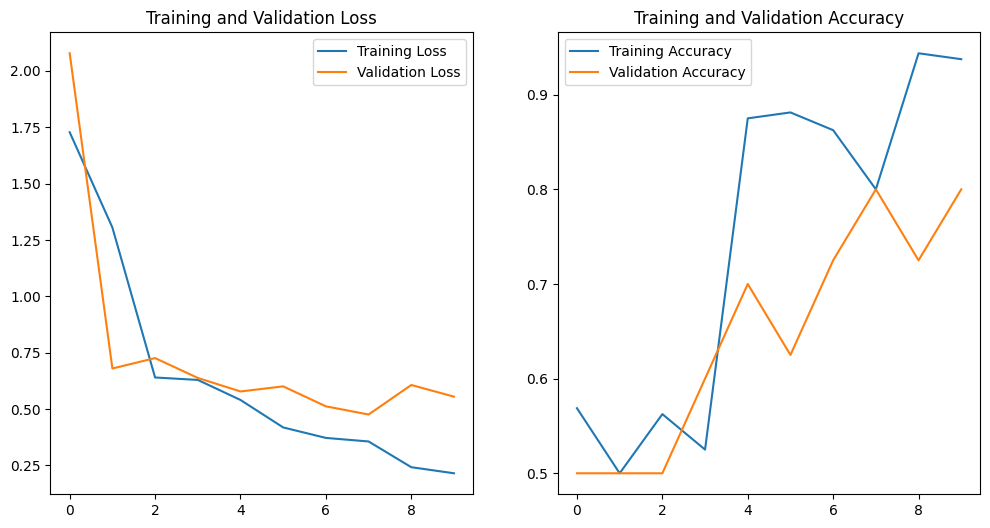

In [ ]:
plot_history(history_1)

### VGG (3 blocks)

In [16]:
def vgg_3_blocks():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
model_2 = vgg_3_blocks()
history_2 = model_2.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    verbose=1
)

results_2 = evaluate_model(model_2, history_2)
print(f"Model 2 Results: {results_2}")

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4708 - loss: 1.0712 - val_accuracy: 0.5000 - val_loss: 0.7288
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4974 - loss: 0.7161 - val_accuracy: 0.5250 - val_loss: 0.6813
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.5422 - loss: 0.6890 - val_accuracy: 0.7000 - val_loss: 0.6588
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8208 - loss: 0.6382 - val_accuracy: 0.6250 - val_loss: 0.6122
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.7099 - loss: 0.5612 - val_accuracy: 0.6750 - val_loss: 0.5520
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.7927 - loss: 0.5070 - val_accuracy: 0.7250 - val_loss: 0.5489
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8146 - loss: 0.4214 - val_accuracy: 0.7250 - val_loss: 0.5151
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8328 - loss: 0.3942 - val_accuracy: 0.6250 - val_loss: 0.7143
Epoch 9/10
3/3 

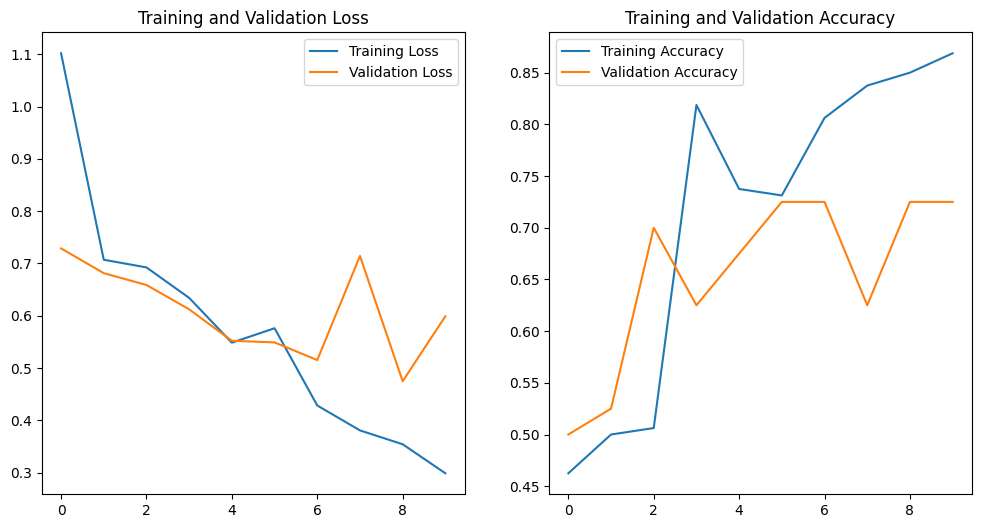

In [ ]:
plot_history(history_2)

### VGG (3 blocks) with data augmentation

In [20]:
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_aug = aug_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary'
)

Found 160 images belonging to 2 classes.


In [21]:
model_3 = vgg_3_blocks()
history_3 = model_3.fit(
    train_generator_aug,
    epochs=10,
    validation_data=test_generator,
    verbose=1
)

results_3 = evaluate_model(model_3, history_3)
print(f"Model 3 Results: {results_3}")

c:\Users\aashm\OneDrive\Desktop\ES335_gradient_thinkers\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.5566 - loss: 1.2916 - val_accuracy: 0.5000 - val_loss: 0.9353
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4714 - loss: 0.8373 - val_accuracy: 0.5500 - val_loss: 0.6976
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.5191 - loss: 0.6848 - val_accuracy: 0.5000 - val_loss: 0.7220
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4948 - loss: 0.6498 - val_accuracy: 0.5000 - val_loss: 0.6970
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.5375 - loss: 0.6057 - val_accuracy: 0.7000 - val_loss: 0.7198
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7411 - loss: 0.6030 - val_accuracy: 0.6500 - val_loss: 0.6182
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.7630 - loss: 0.5857 - val_accuracy: 0.6750 - val_loss: 0.6244
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7348 - loss: 0.5314 - val_accuracy: 0.7000 - val_loss: 0.6992
Epoch 9/10
3/3 

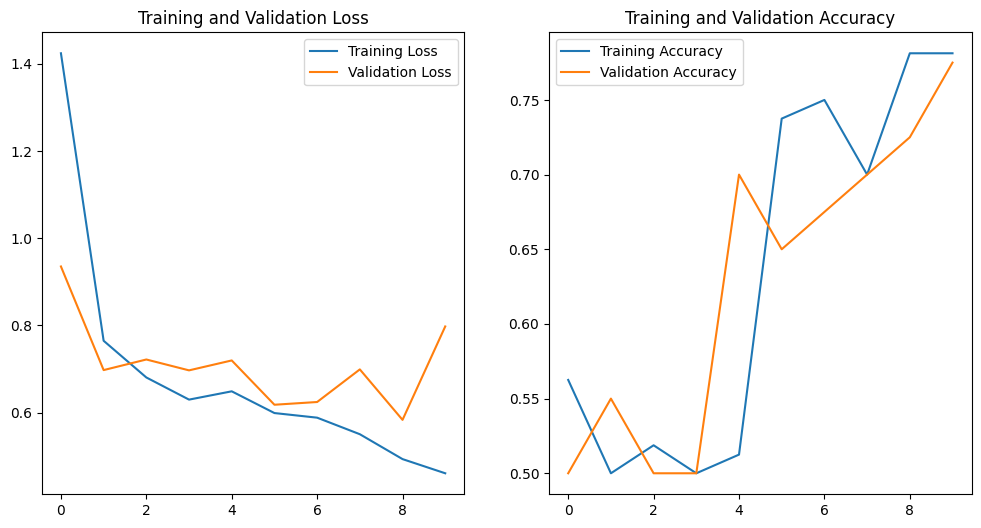

In [ ]:
plot_history(history_3)

### Transfer Learning using VGG16/VGG19 with Fine-tuning All Layer

In [23]:
def transfer_learning_full_finetune():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = True

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [24]:
model_4 = transfer_learning_full_finetune()
history_4 = model_4.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    verbose=1
)

results_4 = evaluate_model(model_4, history_4)
print(f"Model 4 Results: {results_4}")

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 8s/step - accuracy: 0.6807 - loss: 0.6129 - val_accuracy: 0.7750 - val_loss: 0.5581
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 9s/step - accuracy: 0.9573 - loss: 0.4263 - val_accuracy: 0.9500 - val_loss: 0.4306
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.9807 - loss: 0.3018 - val_accuracy: 1.0000 - val_loss: 0.3133
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 11s/step - accuracy: 1.0000 - loss: 0.1946 - val_accuracy: 1.0000 - val_loss: 0.2153
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step - accuracy: 1.0000 - loss: 0.1154 - val_accuracy: 1.0000 - val_loss: 0.1281
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 1.0000 - loss: 0.0579 - val_accuracy: 1.0000 - val_loss: 0.0616
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 1.0000 - loss: 0.0291 - val_accuracy: 1.0000 - val_loss: 0.0300
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 0.0154
Epoch 9

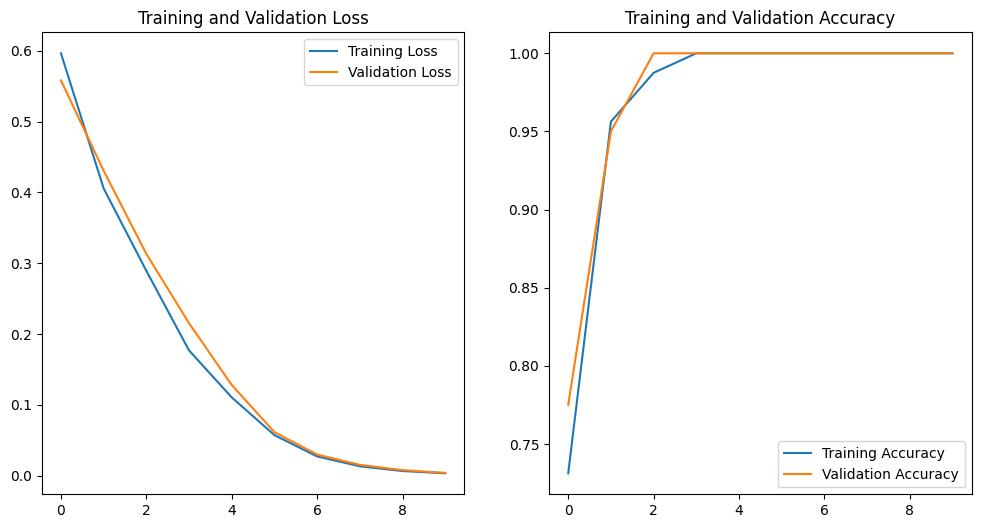

In [ ]:
plot_history(history_4)

### Transfer Learning using VGG16/VGG19 with Fine-tuning Only Final MLP Layers

In [26]:
def transfer_learning_finetune_fc():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False  # Freeze convolutional layers

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [27]:
model_5 = transfer_learning_finetune_fc()
history_5 = model_5.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    verbose=1
)

results_5 = evaluate_model(model_5, history_5)
print(f"Model 5 Results: {results_5}")

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.3250 - loss: 0.7806 - val_accuracy: 0.3000 - val_loss: 0.7868
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.3495 - loss: 0.7397 - val_accuracy: 0.3250 - val_loss: 0.7573
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.4151 - loss: 0.7120 - val_accuracy: 0.4000 - val_loss: 0.7295
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.5206 - loss: 0.6828 - val_accuracy: 0.4750 - val_loss: 0.7039
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6318 - loss: 0.6495 - val_accuracy: 0.5500 - val_loss: 0.6798
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.6854 - loss: 0.6149 - val_accuracy: 0.6000 - val_loss: 0.6565
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.7365 - loss: 0.5919 - val_accuracy: 0.7000 - val_loss: 0.6346
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.8036 - loss: 0.5781 - val_accuracy: 0.7000 - val_loss: 0.6137
Epoch 9/

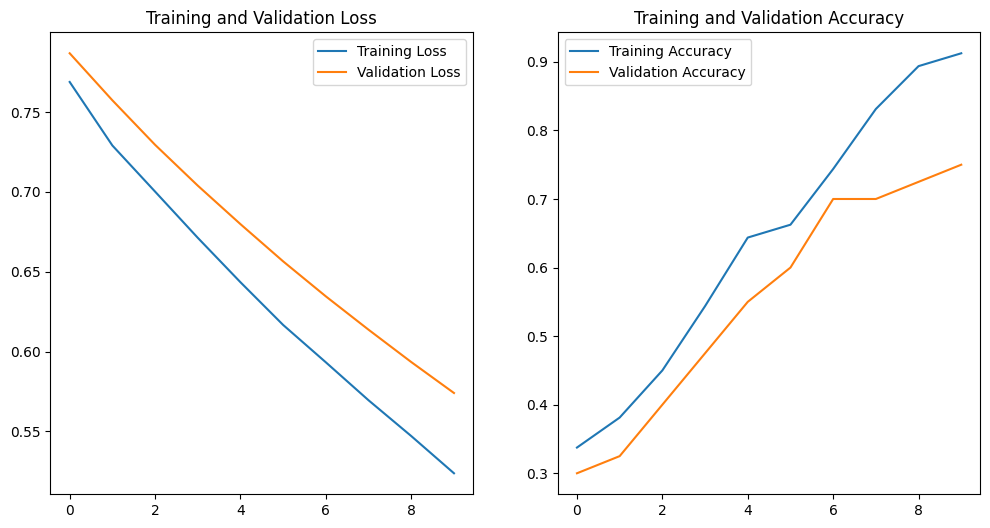

In [ ]:
plot_history(history_5)

## Tensorboard

In [29]:
from torch.utils.tensorboard import SummaryWriter

In [30]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.BinaryAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.BinaryAccuracy('test_accuracy')

In [31]:
def train_step(model, optimizer, x_train, y_train):
  y_train=y_train.reshape(-1,1)
  with tf.GradientTape() as tape:
    predictions = model(x_train, training=True)
    loss = loss_object(y_train, predictions)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  
  train_loss(loss)
  train_accuracy(y_train, predictions)

def test_step(model, x_test, y_test):
  y_test=y_test.reshape(-1,1)
  predictions = model(x_test)
  loss = loss_object(y_test, predictions)

  test_loss(loss)
  test_accuracy(y_test, predictions)

In [41]:
def log_predictions(epoch, model, test_generator, file_writer_pred):
    # Get a batch of test data
    test_images, test_labels = next(test_generator)
    
    # Predict the values from the test dataset (on the batch)
    test_pred_raw = model.predict(test_images)
    #test_pred = np.argmax(test_pred_raw, axis=1)
    test_pred = np.where(test_pred_raw > 0.5, 1, 0)

    # Create an empty figure to log the images with predictions
    fig, axes = plt.subplots(4, 10, figsize=(10, 10))  # Adjust grid size as needed
    for i, ax in enumerate(axes.flat):
        if i < len(test_images):
            ax.imshow(test_images[i])
            ax.set_title(f"True: {test_labels[i]}, Pred: {test_pred[i]}",fontsize=2.6)
            ax.axis("off")  # Hide the axis
    
    # Convert the plot to a tensor and log it with TensorBoard
    plt.tight_layout()
    fig.canvas.draw()
    img_data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img_data = img_data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)

    with file_writer_pred.as_default():
        tf.summary.image("Test Predictions", np.expand_dims(img_data, axis=0), step=epoch)

In [53]:
def train_and_evaluate(model, train_generator, test_generator, logdir, epochs=5):
    """
    Function to train and evaluate a model using a given dataset and log metrics.
    
    Args:
        model: The TensorFlow/Keras model to be trained.
        train_generator: The generator providing training data batches.
        test_generator: The generator providing test data batches.
        optimizer: The optimizer to use for training.
        loss_object: The loss function to use for training.
        logdir: Directory for logging summaries.
        epochs: Number of epochs to train for (default: 5).
    """
    # Define summary writers
    train_summary_writer = tf.summary.create_file_writer(logdir + '/train')
    test_summary_writer = tf.summary.create_file_writer(logdir + '/test')
    file_writer_pred = tf.summary.create_file_writer(logdir + '/predictions')

    optimizer = tf.keras.optimizers.Adam()
    loss_object = tf.keras.losses.BinaryCrossentropy() 
    
    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training step loop
        count = 0
        for batch, (x_train, y_train) in enumerate(train_generator):
            train_step(model, optimizer, x_train, y_train)

            # Log training loss and accuracy
            with train_summary_writer.as_default():
                tf.summary.scalar('loss', train_loss.result(), step=epoch * len(train_generator) + batch)
                tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch * len(train_generator) + batch)

            count += 1
            if count >= len(train_generator):  # Stop after iterating through the generator
                break

        # Testing step loop
        count = 0
        for batch, (x_test, y_test) in enumerate(test_generator):
            test_step(model, x_test, y_test)

            # Log test loss and accuracy
            with test_summary_writer.as_default():
                tf.summary.scalar('loss', test_loss.result(), step=epoch * len(test_generator) + batch)
                tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch * len(test_generator) + batch)

            count += 1
            if count >= len(test_generator):  # Stop after iterating through the generator
                break

        # Log predictions for the current epoch
        log_predictions(epoch, model, test_generator, file_writer_pred)

        # Print metrics at the end of the epoch
        template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
        print(template.format(epoch + 1,
                              train_loss.result(),
                              train_accuracy.result() * 100,
                              test_loss.result(),
                              test_accuracy.result() * 100))

        # Reset metrics for the next epoch
        train_loss.reset_state()
        test_loss.reset_state()
        train_accuracy.reset_state()
        test_accuracy.reset_state()

In [ ]:
model_1 = vgg_1_block()
train_and_evaluate(
    model=model_1,
    train_generator=train_generator,
    test_generator=test_generator,
    logdir="logs/images_1",
    epochs=5
)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


C:\Users\aashm\AppData\Local\Temp\ipykernel_17120\3700702329.py:21: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Epoch 1, Loss: 2.3726, Accuracy: 58.75%, Test Loss: 1.3140, Test Accuracy: 50.00%
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Epoch 2, Loss: 0.6913, Accuracy: 73.12%, Test Loss: 0.4893, Test Accuracy: 72.50%
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 3, Loss: 0.4575, Accuracy: 74.38%, Test Loss: 0.4462, Test Accuracy: 77.50%
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 4, Loss: 0.2499, Accuracy: 88.12%, Test Loss: 0.4010, Test Accuracy: 82.50%
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 5, Loss: 0.2456, Accuracy: 91.88%, Test Loss: 0.4351, Test Accuracy: 77.50%


In [55]:
model_2 = vgg_3_blocks()
train_and_evaluate(
    model=model_2,
    train_generator=train_generator,
    test_generator=test_generator,
    logdir="logs/images_2",
    epochs=5
)

c:\Users\aashm\OneDrive\Desktop\ES335_gradient_thinkers\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


C:\Users\aashm\AppData\Local\Temp\ipykernel_17120\3700702329.py:21: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Epoch 1, Loss: 1.2047, Accuracy: 55.31%, Test Loss: 0.7948, Test Accuracy: 50.00%
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 2, Loss: 0.7058, Accuracy: 50.00%, Test Loss: 0.6676, Test Accuracy: 55.00%
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 3, Loss: 0.6223, Accuracy: 55.62%, Test Loss: 0.6263, Test Accuracy: 65.00%
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 4, Loss: 0.5714, Accuracy: 77.50%, Test Loss: 0.5333, Test Accuracy: 77.50%
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 5, Loss: 0.5424, Accuracy: 68.75%, Test Loss: 0.4918, Test Accuracy: 82.50%


In [56]:
model_3 = vgg_3_blocks()
train_and_evaluate(
    model=model_3,
    train_generator=train_generator_aug,
    test_generator=test_generator,
    logdir="logs/images_3",
    epochs=5
)

Epoch 1/5

c:\Users\aashm\OneDrive\Desktop\ES335_gradient_thinkers\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


C:\Users\aashm\AppData\Local\Temp\ipykernel_17120\3700702329.py:21: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Epoch 1, Loss: 0.9191, Accuracy: 41.25%, Test Loss: 0.7405, Test Accuracy: 50.00%
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 2, Loss: 0.7007, Accuracy: 51.88%, Test Loss: 0.6918, Test Accuracy: 50.00%
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 3, Loss: 0.6765, Accuracy: 50.00%, Test Loss: 0.6750, Test Accuracy: 50.00%
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 4, Loss: 0.6267, Accuracy: 61.87%, Test Loss: 0.6916, Test Accuracy: 60.00%
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 5, Loss: 0.5602, Accuracy: 73.12%, Test Loss: 0.5670, Test Accuracy: 70.00%


In [57]:
model_4 = transfer_learning_full_finetune()
train_and_evaluate(
    model=model_4,
    train_generator=train_generator,
    test_generator=test_generator,
    logdir="logs/images_4",
    epochs=5
)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step


C:\Users\aashm\AppData\Local\Temp\ipykernel_17120\3700702329.py:21: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Epoch 1, Loss: 1.1570, Accuracy: 55.62%, Test Loss: 7.7208, Test Accuracy: 50.00%
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step
Epoch 2, Loss: 2.9164, Accuracy: 53.12%, Test Loss: 0.7671, Test Accuracy: 50.00%
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Epoch 3, Loss: 0.7290, Accuracy: 51.25%, Test Loss: 3.7384, Test Accuracy: 50.00%
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
Epoch 4, Loss: 1.6465, Accuracy: 50.63%, Test Loss: 0.7100, Test Accuracy: 50.00%
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step
Epoch 5, Loss: 0.7003, Accuracy: 52.50%, Test Loss: 0.6806, Test Accuracy: 62.50%


In [58]:
model_5 = transfer_learning_finetune_fc()
train_and_evaluate(
    model=model_5,
    train_generator=train_generator,
    test_generator=test_generator,
    logdir="logs/images_5",
    epochs=5
)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step


C:\Users\aashm\AppData\Local\Temp\ipykernel_17120\3700702329.py:21: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Epoch 1, Loss: 0.6879, Accuracy: 65.62%, Test Loss: 0.4537, Test Accuracy: 72.50%
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step
Epoch 2, Loss: 0.1437, Accuracy: 95.62%, Test Loss: 0.0585, Test Accuracy: 100.00%
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
Epoch 3, Loss: 0.0623, Accuracy: 96.88%, Test Loss: 0.0255, Test Accuracy: 100.00%
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step
Epoch 4, Loss: 0.0179, Accuracy: 100.00%, Test Loss: 0.0085, Test Accuracy: 100.00%
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step
Epoch 5, Loss: 0.0110, Accuracy: 99.38%, Test Loss: 0.0140, Test Accuracy: 100.00%


In [60]:
import pandas as pd
import time

# Function to capture model stats
def evaluate_model(model, train_data, test_data, epochs):
    # Measure training time
    start_time = time.time()
    history = model.fit(train_data, epochs=epochs, verbose=0)  # Train model
    training_time = time.time() - start_time  # Calculate training time

    # Get the final training loss and accuracy
    training_loss = history.history['loss'][-1]
    training_accuracy = history.history['accuracy'][-1] * 100  # Convert to percentage

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(test_data, verbose=0)
    test_accuracy = test_accuracy * 100  # Convert to percentage

    # Get the number of model parameters
    num_params = model.count_params()

    # Return all metrics
    return {
        'Training Time (s)': round(training_time, 2),
        'Training Loss': round(training_loss, 4),
        'Training Accuracy (%)': round(training_accuracy, 2),
        'Test Accuracy (%)': round(test_accuracy, 2),
        'Number of Parameters': num_params
    }

# Assuming you have multiple models
models = [model_1, model_2, model_3,model_4, model_5]
model_names = ['Model_1','Model_2','Model_3','Model_4','Model_5']

# Empty list to store model results
results = []

# Train and evaluate each model
for model, name in zip(models, model_names):
    if model==model_3:
        model_stats = evaluate_model(model, train_generator_aug, test_generator, epochs=5)
        model_stats['Model'] = name

    model_stats = evaluate_model(model, train_generator, test_generator, epochs=5)
    model_stats['Model'] = name  # Add model name
    results.append(model_stats)

# Create DataFrame from results
df = pd.DataFrame(results)

# Reorder columns
df = df[['Model','Training Time (s)','Training Loss','Training Accuracy (%)','Test Accuracy (%)','Number of Parameters']]

# Display the table
print(df)

     Model  Training Time (s)  Training Loss  Training Accuracy (%)  \
0  Model_1              31.40         0.0093                 100.00   
1  Model_2              79.25         0.3313                  87.50   
2  Model_3              58.71         0.1975                  93.12   
3  Model_4             173.63         0.6730                  65.00   
4  Model_5              97.65         0.0054                 100.00   

   Test Accuracy (%)  Number of Parameters  
0               87.5              10636481  
1               82.5               4828481  
2               82.5               4828481  
3               70.0              15763521  
4              100.0              15763521  


In [ ]:
%tensorboard --logdir logs

In [14]:
class MLPModel(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(MLPModel, self).__init__()
        self.flatten = layers.Flatten(input_shape=input_shape, name="Flatten_Layer")
        self.hidden1 = layers.Dense(4096, activation='relu', name="Dense_Layer_1")
        self.hidden2 = layers.Dense(4096, activation='relu', name="Dense_Layer_2")
        self.hidden3 = layers.Dense(4096, activation='relu', name="Dense_Layer_3")
        self.hidden4 = layers.Dense(2048, activation='relu', name="Dense_Layer_4")
        self.hidden5 = layers.Dense(2048, activation='relu', name="Dense_Layer_5")
        self.hidden6 = layers.Dense(1024, activation='relu', name="Dense_Layer_6")
        self.output_layer = layers.Dense(num_classes, activation='sigmoid', name="Output_Layer")

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.hidden5(x)
        x = self.hidden6(x)
        return self.output_layer(x)

In [24]:
input_shape = (150, 150, 3)
num_classes = 1

# Instantiate and compile the MLP model
mlp_model = MLPModel(input_shape=input_shape, num_classes=num_classes)
mlp_model.build(input_shape=(None, *input_shape))
mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history = mlp_model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator
)

mlp_model.summary()

c:\Users\aashm\OneDrive\Desktop\ES335_gradient_thinkers\.venv\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'mlp_model_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 8s/step - accuracy: 0.4432 - loss: 0.7204 - val_accuracy: 0.5000 - val_loss: 0.6980
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.5378 - loss: 0.6593 - val_accuracy: 0.4750 - val_loss: 0.6849
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.7266 - loss: 0.6192 - val_accuracy: 0.4750 - val_loss: 0.6784
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.7359 - loss: 0.5579 - val_accuracy: 0.6500 - val_loss: 0.6741
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.8034 - loss: 0.5437 - val_accuracy: 0.4750 - val_loss: 0.7084
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.7383 - loss: 0.5207 - val_accuracy: 0.6000 - val_loss: 0.6654
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.8052 - loss: 0.5131 - val_accuracy: 0.6000 - val_loss: 0.6598
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.8125 - loss: 0.4601 - val_accuracy: 0.5000 - val_loss: 0.7277
Epoch 9/

Model: "mlp_model_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten_Layer (Flatten)         │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_1 (Dense)           │ (None, 4096)           │   276,484,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_2 (Dense)           │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_3 (Dense)           │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_4 (Dense)           │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_5 (Dense)           │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_6 (Dense)           │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 974,198,789 (3.63 GB)

 Trainable params: 324,732,929 (1.21 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 649,465,860 (2.42 GB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


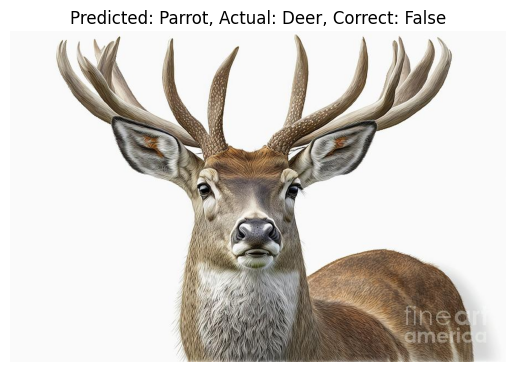

Image 1: Predicted class: Parrot, Actual class: Deer, Correct: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


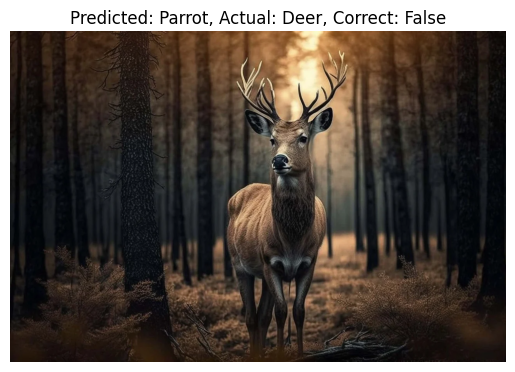

Image 2: Predicted class: Parrot, Actual class: Deer, Correct: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


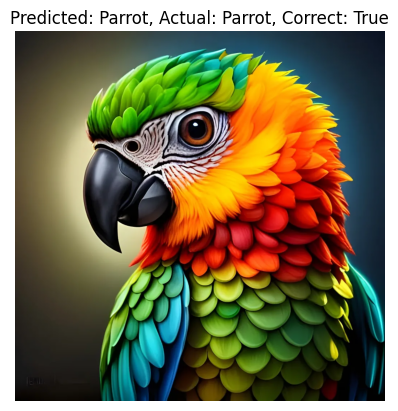

Image 3: Predicted class: Parrot, Actual class: Parrot, Correct: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


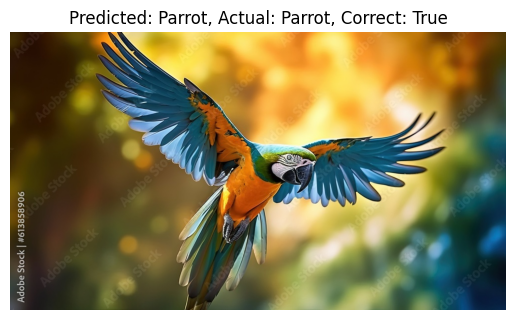

Image 4: Predicted class: Parrot, Actual class: Parrot, Correct: True


In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Define the paths to your images (replace these with your actual file paths)
image_paths = [
    'data/ai/deer_easy.jpg',
    'data/ai/deer_hard.jpg',
    'data/ai/parrot_easy.jpg',
    'data/ai/parrot_hard.jpg',
]

image_labels = [0, 0, 1, 1]  # 0 = Deer, 1 = Parrot

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# Loop over the images, make predictions, and check accuracy
for i, image_path in enumerate(image_paths):
    img = preprocess_image(image_path)
    prediction = mlp_model.predict(img)
    predicted_class = 1 if prediction >= 0.5 else 0
    actual_label = image_labels[i]
    correct = predicted_class == actual_label
    
    img = load_img(image_path)
    plt.imshow(img)
    predicted_class_name = 'Parrot' if predicted_class == 1 else 'Deer'
    actual_class_name = 'Parrot' if actual_label == 1 else 'Deer'
    plt.title(f"Predicted: {predicted_class_name}, Actual: {actual_class_name}, Correct: {correct}")
    plt.axis('off')
    plt.show()
    
    print(f"Image {i+1}: Predicted class: {predicted_class_name}, Actual class: {actual_class_name}, Correct: {correct}")